# Loading Data 

In [72]:
import boto3
import botocore
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# BUCKET_NAME = 'data-set1' # replace with your bucket name
# KEY = 'JAN_DATA/final.xls' # replace with your object key

# s3 = boto3.resource('s3')

# try:
#     s3.Bucket(BUCKET_NAME).download_file(KEY, 'January_Data')
# except botocore.exceptions.ClientError as e:
#     if e.response['Error']['Code'] == "404":
#         print("The object does not exist.")
#     else:
#         raise

In [73]:
df = pd.read_csv("January_Data")

# IBM REST API

In [75]:
import json
import csv 
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_watson.natural_language_understanding_v1 import Features, EntitiesOptions, KeywordsOptions, DocumentSentimentResults, CategoriesOptions, EmotionOptions

In [74]:
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

#Authentication via IAM
authenticator = IAMAuthenticator('INSERT')
service = NaturalLanguageUnderstandingV1(
    version='2018-03-16',
    authenticator=authenticator)
service.set_service_url('INSERT')

#####  Sample Usage

In [83]:
# response = service.analyze(
#                             text=df["Tweet"][98],
#                             features = Features(sentiment= DocumentSentimentResults(), categories=CategoriesOptions(limit=1), keywords=KeywordsOptions(limit=1), emotion=EmotionOptions())
#            ).get_result()

In [84]:
# response['categories'][0]['label']

# Utilities

In [85]:
def get_sample(df, nums):
    return df[nums:nums + 50]

def perform(df_try):
    data = pd.DataFrame(columns=["Tweet", "Language", "Sentiment", "Emotion", "Keyword","Categories"])
    
    for tweet in df_try["Tweet"]:
        try:
            tw = tweet
            response = service.analyze(text=tweet, features = Features(sentiment= DocumentSentimentResults(), emotion=EmotionOptions(), keywords=KeywordsOptions(), categories=CategoriesOptions())).get_result()
        except:
            print("Error in Tweet: ", tw)
            continue
            
        try:
            lan = response["language"]
            sent = response["sentiment"]["document"]["label"]
        except:
            lan = 'en'
            sent = 'neutral'
            
        ans = -1
        place = -1
        emotion = []
        try:
            for i in response["emotion"]["document"]["emotion"]:
                emotion.append(response["emotion"]["document"]["emotion"][i])
            for j in range(len(emotion)):
                if emotion[j] > ans:
                    ans  = emotion[j]
                    place = j
            if (place == 0):
                emot = 'sadness'
            elif (place == 1):
                emot = 'joy'
            elif (place == 2):
                emot = 'fear'
            elif (place == 3):
                emot = 'disgust'
            else:
                emot = 'anger'
            
        except:
            emot = "sadness"
            
        try:
            word = response["keywords"][0]["text"]
        except:
            word = '----'
            
        try:
            cat = response['categories'][0]['label']
        except:
            cat = 'Unknown'
            
        final = {"Tweet":tw, "Language":lan, "Sentiment":sent, "Emotion":emot, "Keyword":word, "Categories":cat}
        data = data.append(final, ignore_index=True)
    return data

def clean_simple(x):
    a = []
    for tw in x:
        tw = tw.lower()
        if (tw.startswith('rt') and tw.endswith('...')):
            continue
        if (tw.startswith('rt')):
            tw = tw[2:]
        a.append(' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",tw).split()))
            
    return set(a)

def analyse_tweet(df):
    df = df.drop_duplicates(subset = "Tweet")
    df = df.sort_values(by = ["Retweets"], ascending=False)
    df = df.reset_index(drop = True)
    del df["Timestamp"], df["Retweets"], df["Location"]
    x = set(df["Tweet"])
    a = clean_simple(x)
    a = list(a)
    a = a[1:]
    dff = pd.DataFrame(a, columns=["Tweet"])
    return dff

def remove_short(df):
    df.drop(df[df['Length'] < 30].index, inplace = True) 
    return df

def extract_information(df):
    print("Converting Data into suitable format...")
    df = analyse_tweet(df)
    
    print("Removing tweets with characters below 30.")
    lengths = []
    for i in df["Tweet"]:
        l = len(i)
        lengths.append(l)
    df["Length"] = lengths
    df = remove_short(df)
    del df["Length"]
    
    print("Data format complete!")
    
    md = pd.DataFrame(columns=["Tweet", "Language", "Sentiment", "Emotion", "Keyword", "Categories"])
    nums = 0
    while (nums < df.shape[0]):
        print("Getting results:", (nums/df.shape[0])*100, "%...")
        df_mini = get_sample(df, nums)
        df_mini = df_mini.reset_index(drop = True)
        df_res = perform (df_mini)
        md = pd.concat([md, df_res], axis=0)
        nums = nums + 50
    print("Analysis complete!")
    print()
    return md

In [87]:
def main_helper(dataframe):
    size = dataframe.shape[0]
    i = 0;
    helper = pd.DataFrame(columns=["Tweet", "Language", "Sentiment", "Emotion", "Keyword", "Categories"])
    while (i <= size):
        res = extract_information(dataframe[i:i + 100])
        i = i + 100
        helper = pd.concat([final, res], axis=0)
    helper.reset_index(drop = True)
    return helper

In [86]:
def main(df, chunksize = 200):
    final = pd.DataFrame(columns=["Tweet", "Language", "Sentiment", "Emotion", "Keyword", "Categories"])
    for i in range(0, df.shape, chunksize):
        print("CHUNK", i, "TO", i + chunksize)
        helper = main_helper(df[i:i + chunksize])
        final = pd.concat([final, helper], axis=0)
        print()
    final.reset_index(drop = True)
    return final

# Call Function

1. Pass complete Dataframe without any changes. Should contain column "Tweet"

In [88]:
# final = main(df)

In [89]:
# md = final.reset_index(drop = True)

In [91]:
# md.shape

In [90]:
# md.head()

In [92]:
# md.to_csv('result_5000.csv')

# EDA of Results

Text(0.5, 1.0, 'Dataset labels distribuition')

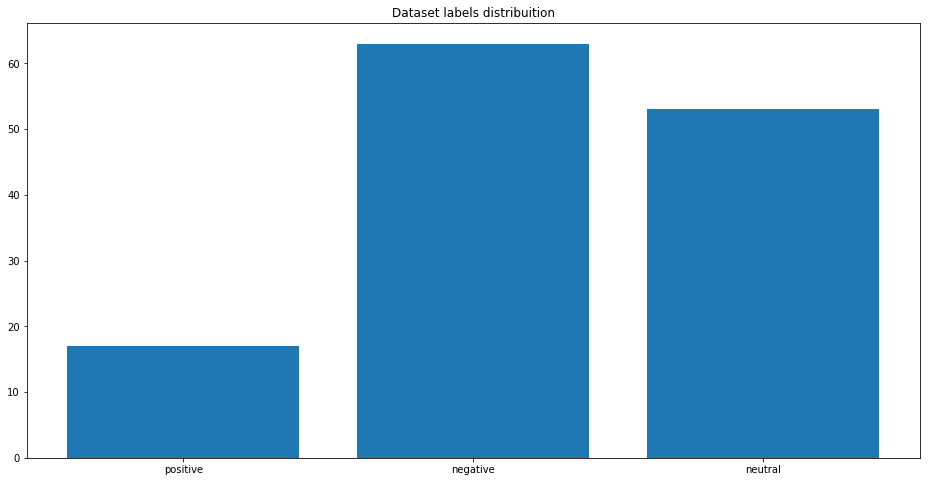

In [58]:
target_cnt = Counter(md.Sentiment)
plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

Text(0.5, 1.0, 'Emotion distribuition')

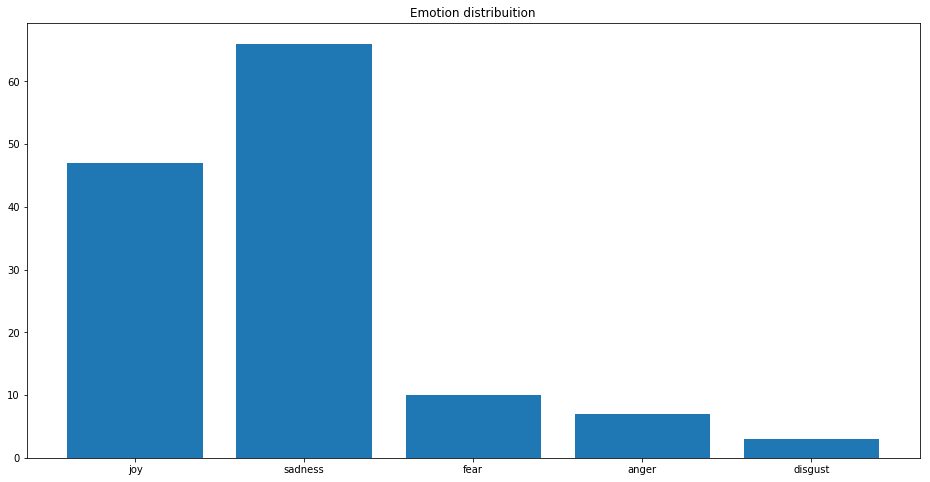

In [59]:
target_cnt = Counter(md.Emotion)
plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Emotion distribuition")

In [60]:
keywords = md["Keyword"]

In [61]:
freq = {} 
for item in keywords: 
    if (item in freq): 
        freq[item] += 1
    else: 
        freq[item] = 1

In [62]:
freq = dict(sorted(freq.items(), key=lambda x: x[1], reverse=True))

In [63]:
count = Counter(freq)

In [64]:
a = dict(count.most_common(7))

Text(0.5, 1.0, 'Top KeyWords')

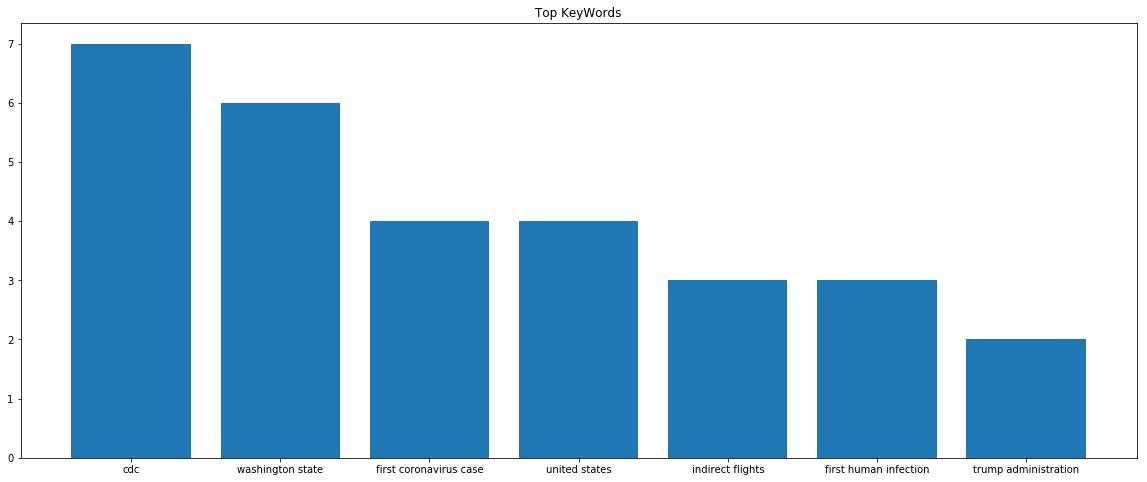

In [65]:
plt.figure(figsize=(20,8))
plt.bar(a.keys(), a.values())
plt.title("Top KeyWords")

In [66]:
cats = md["Categories"]

In [67]:
freq = {} 
for item in cats: 
    if (item in freq): 
        freq[item] += 1
    else: 
        freq[item] = 1

In [68]:
freq = dict(sorted(freq.items(), key=lambda x: x[1], reverse=True))

In [69]:
count = Counter(freq)

In [70]:
a = dict(count.most_common(5))

Text(0.5, 1.0, 'Top Categories')

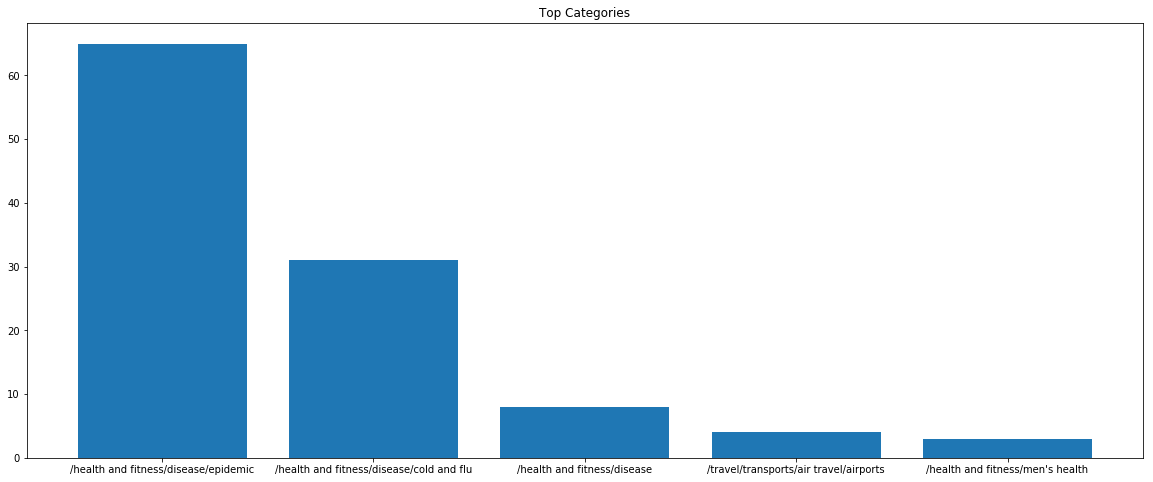

In [71]:
plt.figure(figsize=(20,8))
plt.bar(a.keys(), a.values())
plt.title("Top Categories")